In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
# load perp_margin_vol
perp_margin_vol = pl.read_csv("data/perp_margin_vol.csv")

In [3]:
# convert timestamp to datetime
perp_margin_vol = perp_margin_vol.with_columns(
    pl.col("timestamp").str.to_date(format='%Y-%m-%d')
)

In [4]:
# filter data for dates between 3/1/23 and 5/31/23
perp_margin_vol = perp_margin_vol.filter(
    (pl.col("timestamp") >= pl.date(2023,3,1)) & (pl.col("timestamp") <= pl.date(2023,5,31))
)

In [5]:
perp_margin_vol.head(5)

timestamp,token,volume,protocol
date,str,f64,str
2023-05-31,"""WBTC""",54392435.71589575,"""GMX"""
2023-05-31,"""UNI""",1235628.4661653354,"""GMX"""
2023-05-31,"""WETH""",65987791.631608315,"""GMX"""
2023-05-31,"""LINK""",597849.6116228949,"""GMX"""
2023-05-31,"""AVAX""",1891469.2810495936,"""GMX"""


In [6]:
def standardize_token_names(df: pl.DataFrame, target_symbol_list: list[str], output_symbol: str) -> pl.DataFrame:
    """takes a list of symbols that should be standardized to a single symbol and returns a dataframe with the standardized symbols"""
    for symbol in target_symbol_list:
        df = df.with_columns(
            pl.when(pl.col('token') == symbol).then(pl.lit(output_symbol)).otherwise(pl.col('token')).alias('token')
        )
    
    return df

In [7]:
# if token starts with lowercase s or lowercase v, then drop the letter
no_synth_tokens_df = perp_margin_vol.with_columns(
    pl.when(pl.col('token').str.slice(0,1) == 's').then(pl.col('token').str.slice(1,)).otherwise(pl.col('token')).alias('token')
)

no_perp_tokens_df = no_synth_tokens_df.with_columns(
    pl.when(pl.col('token').str.slice(0,1) == 'v').then(pl.col('token').str.slice(1,)).otherwise(pl.col('token')).alias('token')
)

In [8]:
# remove eth and btc variation names
no_eth_variation_df = standardize_token_names(no_perp_tokens_df, ['ETH'], 'WETH')
no_btc_variation_df = standardize_token_names(no_eth_variation_df, ['BTC', 'BTC.b'], 'WBTC')

# remove "OTHER (<$1.5M)" and "Other (Volume Pair <$1M)" from token
perp_margin_token_vol = no_btc_variation_df.filter(
    (pl.col('token') != 'OTHER (<$1.5M)') & (pl.col('token') != 'Other (Volume Pair <$1M)') & (pl.col('token') != 'Other (Volume <$1M)')
)


### Plot

In [9]:
# convert to pandas
perp_margin_token_vol_pd = perp_margin_token_vol.to_pandas()

In [10]:
# remove timestamp
perp_margin_token_vol_pd = perp_margin_token_vol_pd.drop(columns=['timestamp'])

# group by token, protocl and sum
perp_margin_token_vol_pd = perp_margin_token_vol_pd.groupby(['token', 'protocol']).sum()

In [11]:
# reset index for pivot
perp_margin_token_vol_pd = perp_margin_token_vol_pd.reset_index()

In [12]:
# pivot blockchain column to column headers. Make token the index
pivot_df = perp_margin_token_vol_pd.pivot(index='token', columns='protocol', values='volume')

In [13]:
# create a new sum column
pivot_df['sum'] = pivot_df.sum(axis=1)

In [14]:
# sort
pivot_df = pivot_df.sort_values(by='sum', ascending=True)

In [15]:
pivot_df = pivot_df.tail(15)

In [16]:
pivot_df

protocol,GMX,GNS,KWENTA,LEVEL,MUX,PERP,VERTEX,sum
token,,,,,,,,
AUD,NaN,1.590434e+08,6.799828e+07,NaN,NaN,NaN,NaN,2.270417e+08
FTM,NaN,1.226067e+08,8.492801e+07,NaN,5.389264e+07,4.619987e+07,NaN,3.076272e+08
LINK,1.110198e+08,5.927540e+07,1.330762e+08,NaN,NaN,4.043643e+07,NaN,3.438078e+08
BNB,NaN,1.004004e+08,1.019009e+08,1.521002e+08,1.634055e+07,5.231243e+07,NaN,4.230545e+08
SOL,NaN,1.964351e+08,1.781371e+08,NaN,NaN,5.284178e+07,NaN,4.274140e+08
XAU,NaN,1.378284e+08,3.242738e+08,NaN,NaN,NaN,NaN,4.621022e+08
AVAX,2.629523e+08,6.406995e+07,7.624551e+07,NaN,2.800672e+07,3.730629e+07,NaN,4.685808e+08
OP,NaN,NaN,2.693218e+08,NaN,7.156159e+07,1.616217e+08,NaN,5.025051e+08
MATIC,NaN,2.972316e+08,1.408937e+08,NaN,NaN,6.480743e+07,NaN,5.029327e+08


In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'


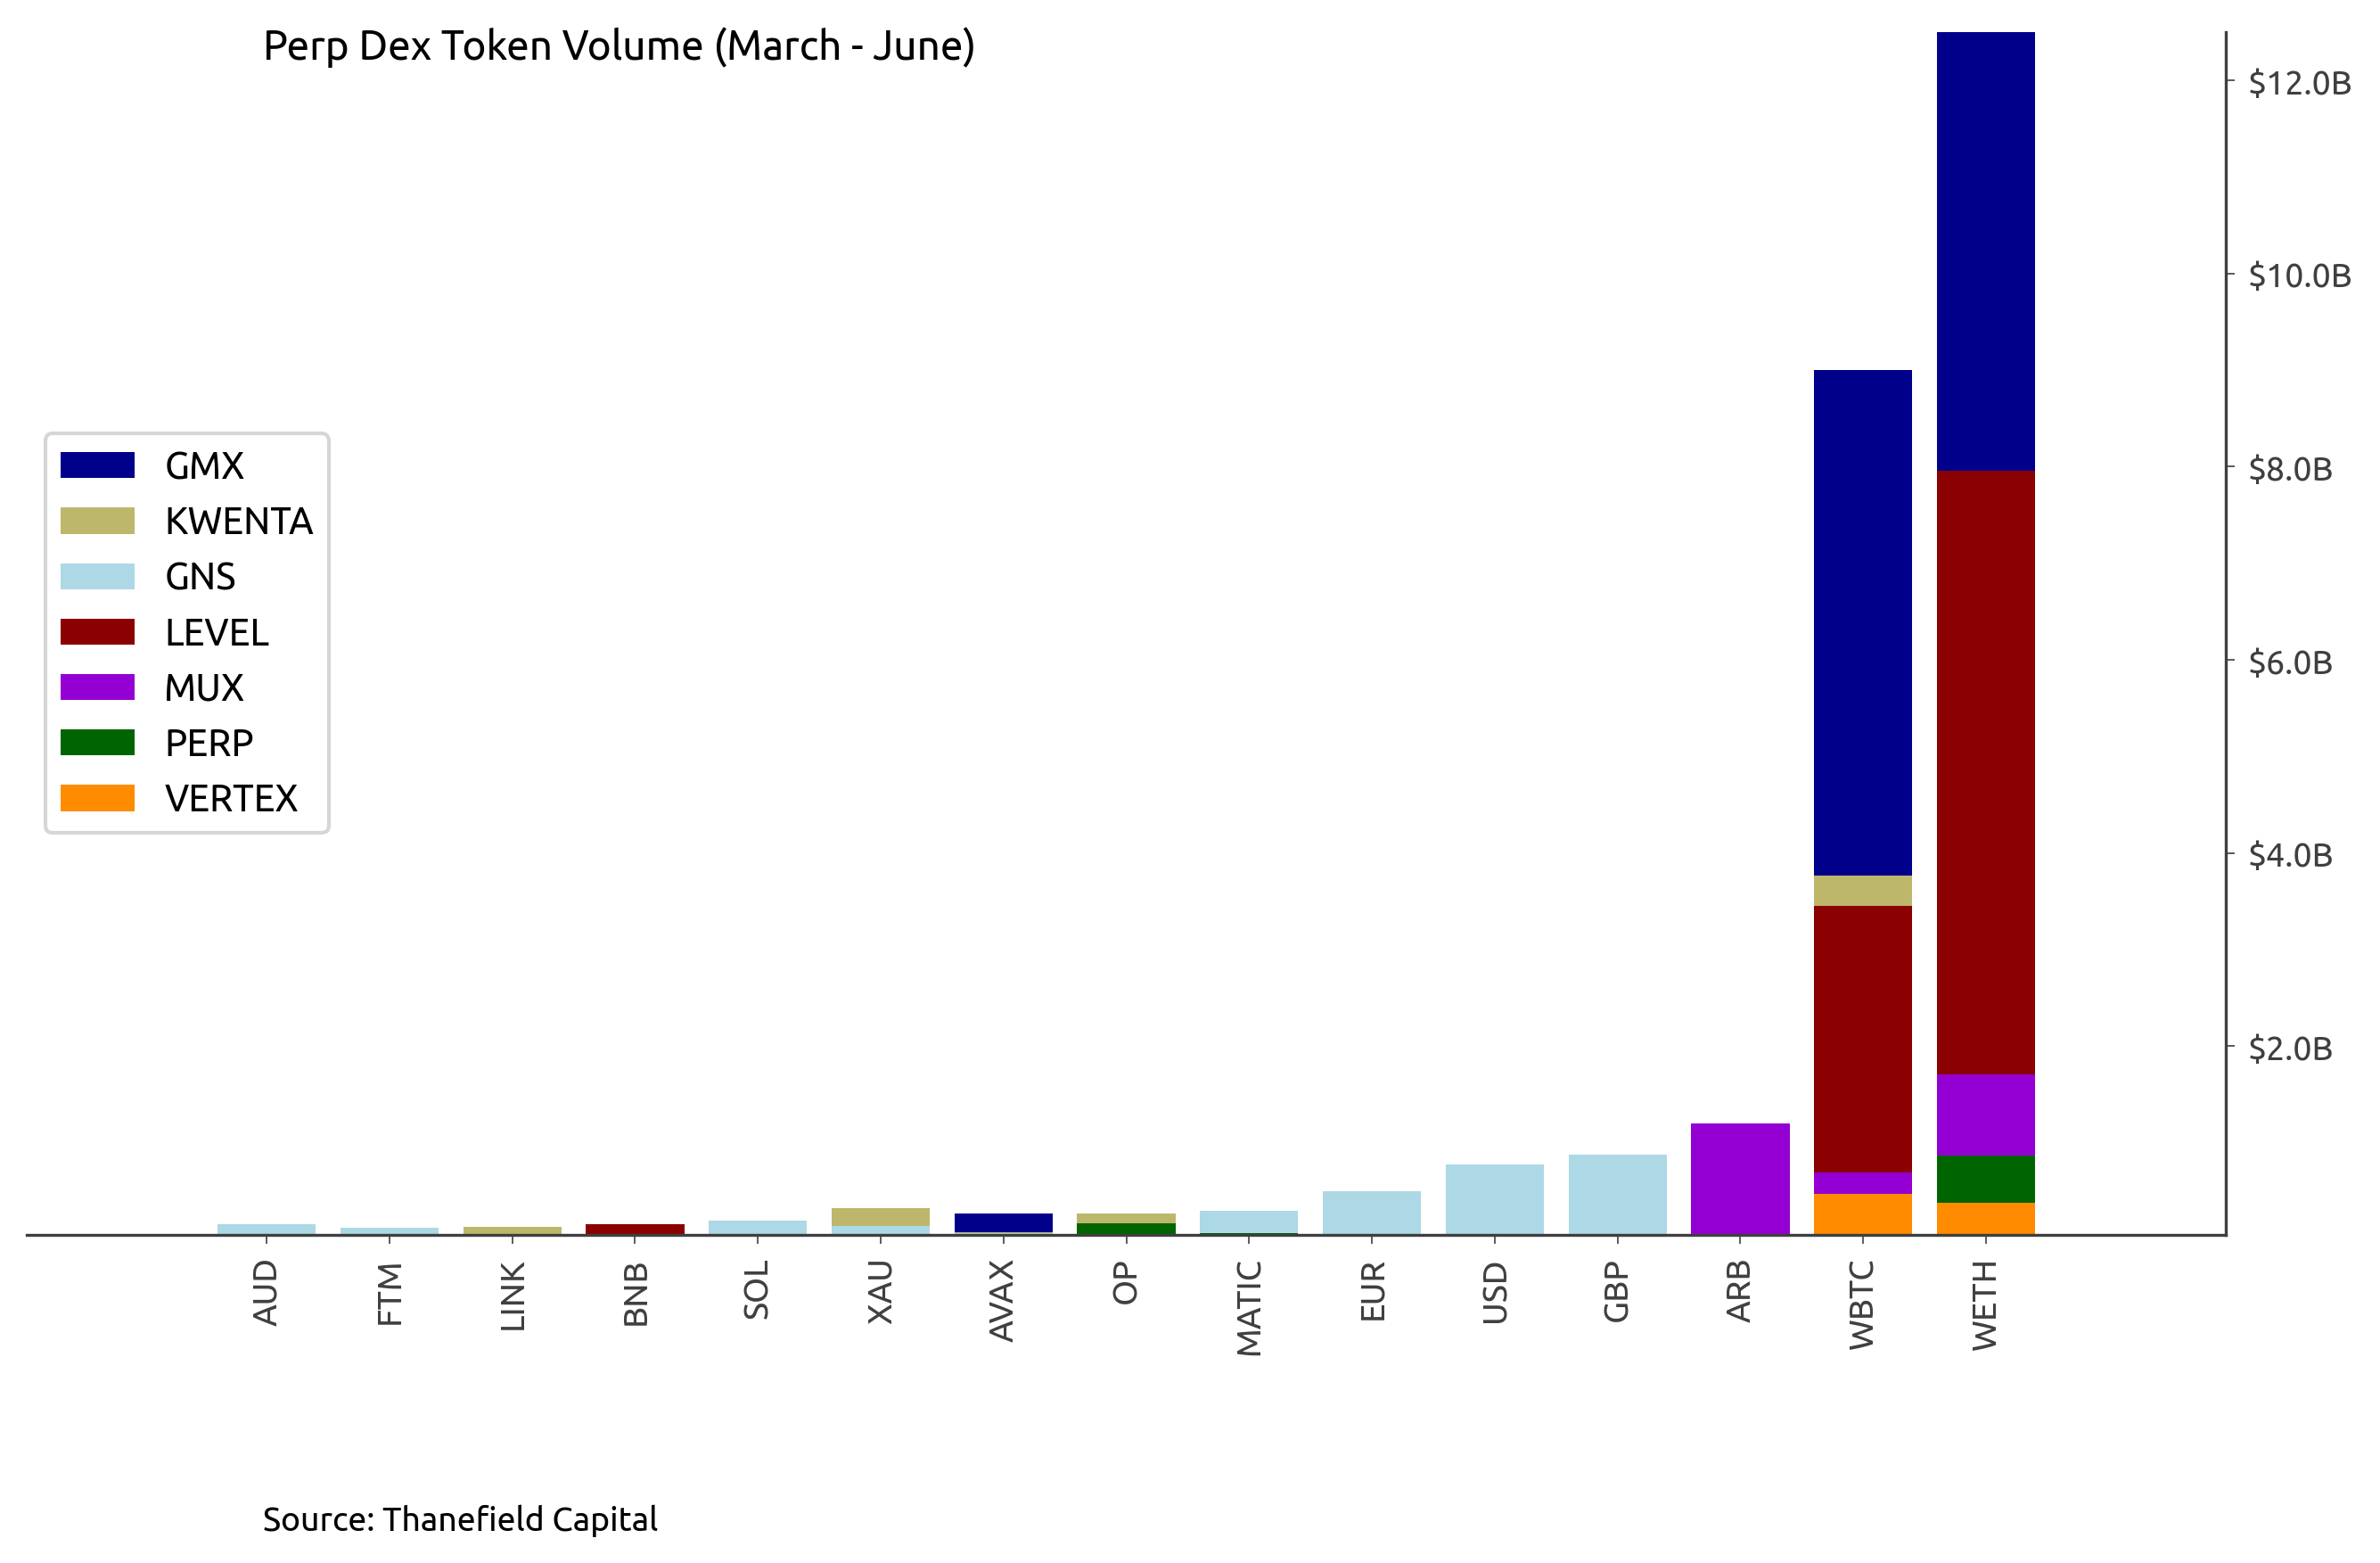

In [24]:
# note each token has over 1b volume
fig, ax = tc.chart('Perp Dex Token Volume (March - June)', dates=False)

ax.bar(pivot_df.index, pivot_df['GMX'], color='darkblue', label='GMX')
ax.bar(pivot_df.index, pivot_df['KWENTA'], color='darkkhaki' , label='KWENTA')
ax.bar(pivot_df.index, pivot_df['GNS'], color='lightblue', label='GNS')
ax.bar(pivot_df.index, pivot_df['LEVEL'], color='darkred', label='LEVEL')
ax.bar(pivot_df.index, pivot_df['MUX'], color='darkviolet', label='MUX')
ax.bar(pivot_df.index, pivot_df['PERP'], color='darkgreen', label='PERP')
ax.bar(pivot_df.index, pivot_df['VERTEX'], color='darkorange', label='VERTEX')

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
# tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(loc='center left')
plt.ylim((5e7,1.25e10))

# save chart
tc.save('charts/perp_dex_total_token_vol.png')